In [9]:
import pandas as pd
import numpy as np

# Load & Preprocess
df = pd.read_csv(r"C:\Users\vvaib\Downloads\k8s_metrics.csv")
df.drop(columns=['API Latency', 'Pod Name'], inplace=True)
df['Anomaly'] = (df['Node Status'] != "Running").astype(int)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values(by='Timestamp')
df['time_since_start'] = (df['Timestamp'] - df['Timestamp'].min()).dt.total_seconds()

# Normalize CPU and Memory
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['CPU Load', 'Memory Usage']] = scaler.fit_transform(df[['CPU Load', 'Memory Usage']])

# Time-windowed features (e.g., past 5 values)
window_size = 5
for col in ['Memory Usage', 'CPU Load']:
    for i in range(1, window_size + 1):
        df[f'{col}_lag{i}'] = df[col].shift(i)

df.dropna(inplace=True)


In [10]:
features = [col for col in df.columns if 'lag' in col or col == 'time_since_start']
X = df[features].values
y = df['Anomaly'].values


In [11]:
features = [col for col in df.columns if 'lag' in col or col == 'time_since_start']
X = df[features].values
y = df['Anomaly'].values


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [13]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

xgb_model = xgb.XGBClassifier(
    scale_pos_weight=np.sum(y_train==0) / np.sum(y_train==1),  # handle imbalance
    eval_metric='auc',
    use_label_encoder=False,
    n_estimators=150,
    max_depth=4,
    learning_rate=0.05
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("\n--- XGBoost Results ---")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb, digits=4))


c:\Users\vvaib\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:37:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- XGBoost Results ---
[[11480   368]
 [    1   141]]
              precision    recall  f1-score   support

           0     0.9999    0.9689    0.9842     11848
           1     0.2770    0.9930    0.4332       142

    accuracy                         0.9692     11990
   macro avg     0.6385    0.9809    0.7087     11990
weighted avg     0.9914    0.9692    0.9777     11990



In [14]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(
    scale_pos_weight=np.sum(y_train==0) / np.sum(y_train==1),
    n_estimators=150,
    learning_rate=0.05,
    class_weight='balanced',
    random_state=42
)

lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

print("\n--- LightGBM Results ---")
print(confusion_matrix(y_test, y_pred_lgb))
print(classification_report(y_test, y_pred_lgb, digits=4))


c:\Users\vvaib\AppData\Local\Programs\Python\Python312\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Number of positive: 568, number of negative: 47391
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 47959, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

--- LightGBM Results ---
[[11602   246]
 [    0   142]]
              precision    recall  f1-score   support

           0     1.0000    0.9792    0.9895     11848
           1     0.3660    1.0000    0.5358       142

    accuracy                         0.9795     11990
   macro avg     0.6830    0.9896    0.7627     11990
weighted avg     0.9925    0.9795    0.9841     11990



In [16]:
from sklearn.metrics import precision_recall_curve

def best_threshold(model, X_val, y_val):
    probs = model.predict_proba(X_val)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_val, probs)
    f1_scores = 2 * precision * recall / (precision + recall + 1e-8)
    best_idx = np.argmax(f1_scores)
    return thresholds[best_idx], f1_scores[best_idx]

thresh, f1 = best_threshold(xgb_model, X_test, y_test)
print(f"\nOptimal threshold (XGB): {thresh:.4f} with F1: {f1:.4f}")

y_thresh_pred = (xgb_model.predict_proba(X_test)[:, 1] > thresh).astype(int)
print(confusion_matrix(y_test, y_thresh_pred))
print(classification_report(y_test, y_thresh_pred, digits=4))



Optimal threshold (XGB): 0.9519 with F1: 0.6212
[[11788    60]
 [   52    90]]
              precision    recall  f1-score   support

           0     0.9956    0.9949    0.9953     11848
           1     0.6000    0.6338    0.6164       142

    accuracy                         0.9907     11990
   macro avg     0.7978    0.8144    0.8059     11990
weighted avg     0.9909    0.9907    0.9908     11990



In [32]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense , Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# Load your dataset
df = pd.read_csv(r"C:\Users\vvaib\Downloads\k8s_metrics.csv")
df.drop(columns=['API Latency', 'Pod Name'], inplace=True)
df['Anomaly'] = (df['Node Status'] != "Running").astype(int)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values(by='Timestamp')

# Normalize memory usage
scaler = MinMaxScaler()
df[['Memory Usage']] = scaler.fit_transform(df[['Memory Usage']])

In [33]:
def create_seq(data, labels, window=10):
    X, y, l = [], [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
        l.append(labels[i+window])
    return np.array(X), np.array(y), np.array(l)

memory = df['Memory Usage'].values
labels = df['Anomaly'].values
X_lstm, y_lstm, l_lstm = create_seq(memory, labels)
X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))

# Train-test split for LSTM
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm, l_train, l_test = train_test_split(
    X_lstm, y_lstm, l_lstm, test_size=0.2, shuffle=False
)

lstm_model = Sequential([
    LSTM(64, input_shape=(X_train_lstm.shape[1], 1)),
     Dense(16, activation='relu'),
     Dropout(0.3),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=32, verbose=0)

# Get LSTM predicted memory
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

c:\Users\vvaib\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step


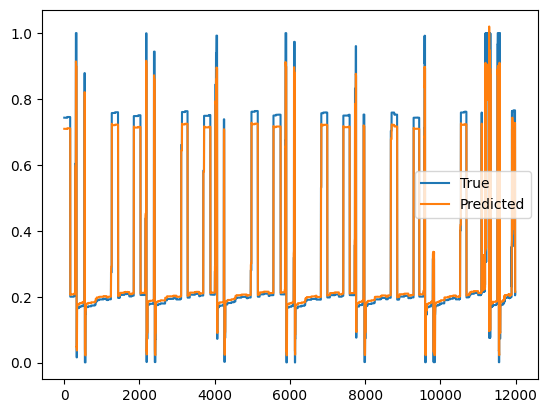

In [34]:
from sklearn.metrics import mean_absolute_error

plt.plot(y_test_lstm, label='True')
plt.plot(y_pred_lstm, label='Predicted')
plt.legend()
plt.show()

[LightGBM] [Info] Number of positive: 130, number of negative: 11859
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 11989, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

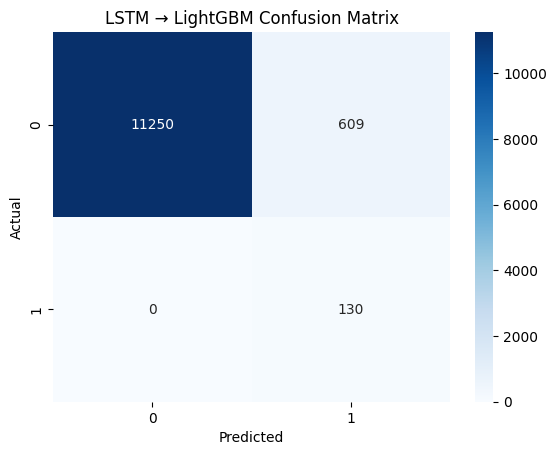

In [37]:
import lightgbm as lgb
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt  # Import sqrt from the math module

# LightGBM input = LSTM predicted memory (reshaped as 2D)
X_gbm = y_pred_lstm.reshape(-1, 1)
y_gbm = l_test  # actual anomaly labels

# Train LightGBM
model_gbm = lgb.LGBMClassifier(
    scale_pos_weight= sqrt(np.sum(y_train==0) / np.sum(y_train==1)),
    n_estimators=150,
    learning_rate=0.05,
    class_weight='balanced',
    random_state=42
)

model_gbm.fit(X_gbm, y_gbm)

# Predict
y_pred_gbm = model_gbm.predict(X_gbm)

# Evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_gbm, y_pred_gbm))

print("\nClassification Report:")
print(classification_report(y_gbm, y_pred_gbm, digits=4))

# Plot
sns.heatmap(confusion_matrix(y_gbm, y_pred_gbm), annot=True, fmt="d", cmap="Blues")
plt.title("LSTM → LightGBM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [40]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

xgb_model = xgb.XGBClassifier(
    scale_pos_weight=  sqrt(np.sum(y_train==0) / np.sum(y_train==1)),  
    eval_metric='auc',
    use_label_encoder=False,
    n_estimators=150,
    max_depth=4,
    learning_rate=0.05
)

xgb_model.fit(X_gbm, y_gbm)
y_pred_xgb = xgb_model.predict(X_gbm)

print("\n--- XGBoost Results ---")
print(confusion_matrix(y_gbm, y_pred_xgb))
print(classification_report(y_gbm, y_pred_xgb, digits=4))

c:\Users\vvaib\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:20:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- XGBoost Results ---
[[11449   410]
 [   19   111]]
              precision    recall  f1-score   support

           0     0.9983    0.9654    0.9816     11859
           1     0.2131    0.8538    0.3410       130

    accuracy                         0.9642     11989
   macro avg     0.6057    0.9096    0.6613     11989
weighted avg     0.9898    0.9642    0.9747     11989

